In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor

In [2]:
import os
import pandas as pd

In [3]:
import torchvision.models as models

In [4]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [9]:
from sklearn.model_selection import train_test_split

In [12]:
# Define the folder containing your images
fakeImage_folder = r'E:\DeepFake\DeepFake\Dataset\ThisPersonDoesNotExist'
realImage_folder = r'E:\DeepFake\DeepFake\Dataset\Real'

# List all image files in the folder
fakeImage_files = [os.path.join(fakeImage_folder, file) for file in os.listdir(fakeImage_folder) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
realImage_files = [os.path.join(realImage_folder, file) for file in os.listdir(realImage_folder) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

fake_df = pd.DataFrame(columns=['Image_Path', 'Fake'])

fake_df['Image_Path'] = fakeImage_files
fake_df['Fake'] = 1

real_df = pd.DataFrame(columns=['Image_Path', 'Fake'])
real_df['Image_Path'] = realImage_files
real_df['Fake'] = 0

result_df = pd.concat([fake_df, real_df[:100]])

In [13]:
result_df

,Image_Path,Fake
0,E:\DeepFake\DeepFake\Dataset\ThisPersonDoesNot...,1
1,E:\DeepFake\DeepFake\Dataset\ThisPersonDoesNot...,1
2,E:\DeepFake\DeepFake\Dataset\ThisPersonDoesNot...,1
3,E:\DeepFake\DeepFake\Dataset\ThisPersonDoesNot...,1
4,E:\DeepFake\DeepFake\Dataset\ThisPersonDoesNot...,1
...,...,...
95,E:\DeepFake\DeepFake\Dataset\Real\00095.png,0
96,E:\DeepFake\DeepFake\Dataset\Real\00096.png,0
97,E:\DeepFake\DeepFake\Dataset\Real\00097.png,0
98,E:\DeepFake\DeepFake\Dataset\Real\00098.png,0


In [14]:
# Split the data into a training set and a test set (50% each) with class balance
X_train, X_test, y_train, y_test = train_test_split(result_df['Image_Path'], result_df['Fake'], test_size=0.9, stratify= result_df['Fake'], random_state=35)

In [15]:
class ImageModel(nn.Module):
    def __init__(self, num_classes):
        super(ImageModel, self).__init__()
        model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.DEFAULT)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.3)
        self.linear1 = nn.Linear(2048, num_classes)

    def forward(self, x):
        batch_size, c, h, w = x.shape
        x = x.view(batch_size, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, 2048)
        x = self.relu(x)
        x = self.dp(x)
        x = self.linear1(x)
        return fmap, x

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
# Load model
model = ImageModel(num_classes=2)
model.load_state_dict(torch.load(r'E:\DeepFake\DeepFake\model\lstm_model7_0.02736789979094257_0.9897857142857143.pth'))
model = model.to(device)

In [20]:
num_epochs = 1000
batch_size = 16

In [22]:
class FaceDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [24]:
transform = transforms.Compose([ transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [25]:
test_dataset = FaceDataset(X_test.values, y_test.values, transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [26]:
model.eval()
allLabels = []
allPredictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        _, outputs = model(inputs)

        # Assuming outputs[:, 1] is the probability of being in class 1
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()

        allLabels.extend(labels.cpu().numpy())
        allPredictions.extend(predictions)

accuracy = accuracy_score(allLabels, allPredictions)
precision = precision_score(allLabels, allPredictions)
recall = recall_score(allLabels, allPredictions)
f1 = f1_score(allLabels, allPredictions)

In [27]:
# Assuming outputs[:, 1] is the probability of being in class 1 (for AUC-ROC)
auc_roc = roc_auc_score(allLabels, allPredictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.6000
Precision: 0.8462
Recall: 0.2444
F1 Score: 0.3793
AUC-ROC: 0.6000


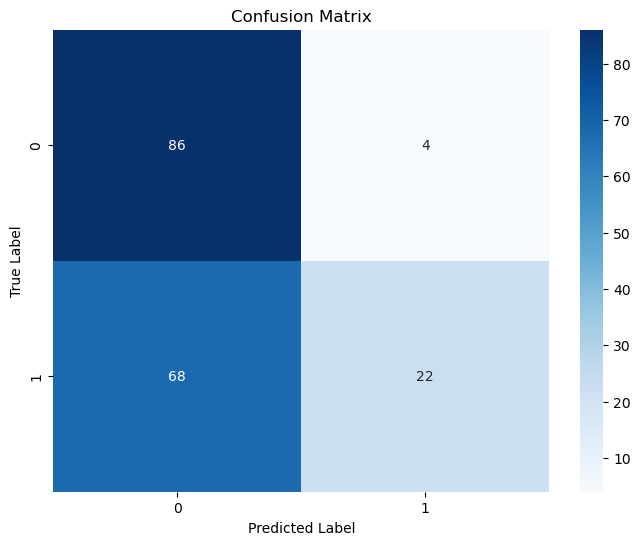

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
cm = confusion_matrix(allLabels, allPredictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [55]:
# Load model
model = ImageModel(num_classes=2)
model.load_state_dict(torch.load(r'E:\DeepFake\DeepFake\model\lstm_model7_0.02736789979094257_0.9897857142857143.pth'))
model = model.to(device)

In [56]:
# Step 3: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [57]:
# Split the data into a training set and a test set (50% each) with class balance
X_train, X_test, y_train, y_test = train_test_split(result_df['Image_Path'], result_df['Fake'], test_size=0.1, stratify= result_df['Fake'], random_state=35)

In [58]:
train_dataset = FaceDataset(X_train.values, y_train.values, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = FaceDataset(X_test.values, y_test.values, transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [59]:
best_val_acc = 0.0
patience = 3  # Number of epochs to wait for improvement
early_stopping_counter = 0
num_epochs = 50

In [60]:
for epoch in range(num_epochs):
    model.train()
    tt_loss = 0.0
    correct_predictions = 0
    tt_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        _, predictions = model(inputs)
        loss = criterion(predictions, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions, 1)
        correct_predictions += (predicted == labels).sum().item()
        tt_samples += labels.size(0)
        tt_loss += loss.item()

    avg_loss = tt_loss / len(train_loader)
    acc = correct_predictions / tt_samples

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            _, val_predictions = model(val_inputs)
            val_loss += criterion(val_predictions, val_labels).item()

            _, val_predicted = torch.max(val_predictions, 1)
            val_correct_predictions += (val_predicted == val_labels).sum().item()
            val_samples += val_labels.size(0)

    avg_val_loss = val_loss / len(test_loader)
    val_acc = val_correct_predictions / val_samples

    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # Check for improvement in accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stopping_counter = 0
        # Save the model
        model_path = f'E:\DeepFake\DeepFake\model\lstm_model_{epoch}_{avg_loss}_{val_acc}.pth'
        print('Saving model:', model_path)
        torch.save(model.state_dict(), model_path)
    else:
        early_stopping_counter += 1

    # Check for early stopping
    if early_stopping_counter >= patience:
        print(f'Early stopping at epoch {epoch+1} due to lack of improvement in accuracy.')
        break

Epoch [1/50], Loss: 1.1329, Accuracy: 0.8000
Validation Loss: 2.0844, Validation Accuracy: 0.7000
Saving model: E:\DeepFake\DeepFake\model\lstm_model_0_1.1329352245666087_0.7.pth
Epoch [2/50], Loss: 0.1389, Accuracy: 0.9556
Validation Loss: 0.9744, Validation Accuracy: 0.7500
Saving model: E:\DeepFake\DeepFake\model\lstm_model_1_0.13894199230708182_0.75.pth
Epoch [3/50], Loss: 0.0877, Accuracy: 0.9722
Validation Loss: 1.2274, Validation Accuracy: 0.7500
Epoch [4/50], Loss: 0.0127, Accuracy: 0.9944
Validation Loss: 0.6677, Validation Accuracy: 0.8000
Saving model: E:\DeepFake\DeepFake\model\lstm_model_3_0.012725449865683913_0.8.pth
Epoch [5/50], Loss: 0.0087, Accuracy: 1.0000
Validation Loss: 0.8652, Validation Accuracy: 0.8000
Epoch [6/50], Loss: 0.0518, Accuracy: 0.9944
Validation Loss: 0.4869, Validation Accuracy: 0.8000
Epoch [7/50], Loss: 0.0227, Accuracy: 0.9944
Validation Loss: 1.4253, Validation Accuracy: 0.6500
Early stopping at epoch 7 due to lack of improvement in accuracy.
